In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import sklearn
import pandas as pd
import os
import sys
import time
import tensorflow as tf

from tensorflow import keras

print(tf.__version__)
print(sys.version_info)
for module in mpl,np,pd,sklearn,tf,keras:
    print(module.__name__,module.__version__)

tf.test.is_gpu_available()

2.0.0
sys.version_info(major=3, minor=6, micro=9, releaselevel='final', serial=0)
matplotlib 3.1.2
numpy 1.17.4
pandas 0.25.3
sklearn 0.22
tensorflow 2.0.0
tensorflow_core.keras 2.2.4-tf


False

In [2]:
fashion_mnist = keras.datasets.fashion_mnist # 这个会去“.keras的目录下去找数据”
(x_train_all,y_train_all),(x_test,y_test) = fashion_mnist.load_data()
x_valid,x_train = x_train_all[:5000],x_train_all[5000:] # 前5000当验证集，后面55000当训练集
y_valid,y_train = y_train_all[:5000],y_train_all[5000:]

print(x_valid.shape,y_valid.shape)
print(x_train.shape,y_train.shape)
print(x_test.shape,y_test.shape)

(5000, 28, 28) (5000,)
(55000, 28, 28) (55000,)
(10000, 28, 28) (10000,)


In [3]:
# 对数据进行归一化处理 ： x = (x-u) / std
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler() # 使用scaler来做数据归一化
# 归一化的使用先把x_train:[None,28,28] -> [None,784];然后归一化之后再把shape变回[None,28,28]
x_train_scaled = scaler.fit_transform(
    x_train.astype(np.float32).reshape(-1,1)).reshape(-1,28,28) 
x_valid_scaled = scaler.fit_transform(
    x_valid.astype(np.float32).reshape(-1,1)).reshape(-1,28,28)
x_test_scaled = scaler.fit_transform(
    x_test.astype(np.float32).reshape(-1,1)).reshape(-1,28,28)

In [4]:
# 定义model
model = keras.models.Sequential()
model.add(keras.layers.Flatten(input_shape=[28,28]))
for _ in range(20): # 利用for循环添加多册dnn网络
    model.add(keras.layers.Dense(100,activation="relu"))
    # 在激活后进行批归一化
    model.add(keras.layers.BatchNormalization())
    """
    # 这种是在批归一化之后再进行激活的方式
    model.add(keras.layers.Dense(100))
    model.add(keras.layers.BatchNormalization())
    model.add(keras.layers.Activation('relu'))
    """
model.add(keras.layers.Dense(10,activation='softmax'))

# optimizer = keras.optimizers.Adam()
# 如果y是是一个one-hot向量，那么使用“categorical_crossentropy”，如果y是一个数，那么使用"sparse_categorical_crossentropy"
model.compile(loss="sparse_categorical_crossentropy", 
              optimizer = 'sgd',
              metrics = ["accuracy"])

In [5]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 784)               0         
_________________________________________________________________
dense (Dense)                (None, 100)               78500     
_________________________________________________________________
batch_normalization (BatchNo (None, 100)               400       
_________________________________________________________________
dense_1 (Dense)              (None, 100)               10100     
_________________________________________________________________
batch_normalization_1 (Batch (None, 100)               400       
_________________________________________________________________
dense_2 (Dense)              (None, 100)               10100     
_________________________________________________________________
batch_normalization_2 (Batch (None, 100)               4

In [7]:
# 定义callbacks : Tensorboard, earlystopping, ModelCheckpoint
logdir = './dnn-bn-callbacks'
if not os.path.exists(logdir):
    os.mkdir(logdir)
output_model_file = os.path.join(logdir, 
                                 'fashion_mnist_model.h5')
callbacks = [
    keras.callbacks.TensorBoard(logdir),
    # save_best_only= True 保存最好的模型
    keras.callbacks.ModelCheckpoint(output_model_file,
                                   save_best_only= True),
    # earlystopping：monitor:关注的指标；默认是'val_loss'
    # min_delta:关注的指标变化小于这个阈值时可能需要earlystopping
    # patience: 一个数字，代表当发生多少次变化小于min_delta是我们要earlystopping
    keras.callbacks.EarlyStopping(min_delta=1e-3,patience=5)
]

# 开始训练:使用归一化的数据
history = model.fit(x_train_scaled,y_train,epochs=10,
          validation_data=(x_valid_scaled,y_valid),
          callbacks=callbacks)

Train on 55000 samples, validate on 5000 samples
Epoch 1/10
55000/55000 [==============================] - 9s 155us/sample - loss: 0.7475 - accuracy: 0.7279 - val_loss: 0.5395 - val_accuracy: 0.8110
Epoch 2/10
55000/55000 [==============================] - 9s 161us/sample - loss: 0.6513 - accuracy: 0.7693 - val_loss: 0.4749 - val_accuracy: 0.8332
Epoch 3/10
55000/55000 [==============================] - 10s 188us/sample - loss: 0.5977 - accuracy: 0.7907 - val_loss: 0.4724 - val_accuracy: 0.8330
Epoch 4/10
55000/55000 [==============================] - 10s 188us/sample - loss: 0.5500 - accuracy: 0.8068 - val_loss: 0.4483 - val_accuracy: 0.8384
Epoch 5/10
55000/55000 [==============================] - 10s 188us/sample - loss: 0.5180 - accuracy: 0.8173 - val_loss: 0.4144 - val_accuracy: 0.8604
Epoch 6/10
55000/55000 [==============================] - 10s 187us/sample - loss: 0.4896 - accuracy: 0.8301 - val_loss: 0.4184 - val_accuracy: 0.8558
Epoch 7/10
55000/55000 [=======================

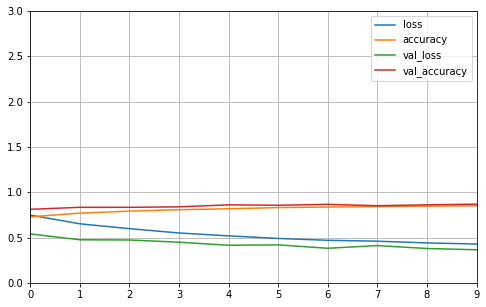

In [8]:
# 把值的变化过程打印出来
def plot_learning_curves(history):
    pd.DataFrame(history.history).plot(figsize=(8,5))
    plt.grid(True)
    plt.gca().set_ylim(0,3)
    plt.show()

plot_learning_curves(history)

# 1.参数众多，训练不充分
# 2.梯度消失->链式法则->复合函数f(g(x))
#   批归一化可以缓解梯度消失

In [9]:
model.evaluate(x_test_scaled,y_test)

10000/1 [===============================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

[0.3991059198856354, 0.8612]